In [1]:
import torchvision
import torch.nn as nn
import torch
import torch.functional as F
from torchvision import transforms, models, datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
device = torch.device('mps' if torch.backends.mps.is_available()  else 'cpu')
import cv2, glob, pandas as pd
from glob import glob
import os
from torchsummary import summary

In [2]:
# ----------------------------
# Device setup
# ----------------------------
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: mps


In [3]:
# ----------------------------
# Paths and parameters
# ----------------------------
data_dir = "dataset/целостность"
batch_size = 32
num_epochs_stage1 = 6
num_epochs_stage2 = 20
learning_rate_stage1 = 1e-3
learning_rate_stage2 = 1e-4
num_classes = 2  # dusty / clean

In [4]:
# ----------------------------
# Dataset preparation
# ----------------------------
# Get list of all image paths and labels
from sklearn.model_selection import train_test_split
import copy
clean_paths = glob(os.path.join(data_dir, "небитыйджпег", "*.jpeg"))
dirty_paths = glob(os.path.join(data_dir, "битыйджпег", "*.jpeg"))

all_paths = clean_paths + dirty_paths
all_labels = [0]*len(clean_paths) + [1]*len(dirty_paths)  # 0=clean, 1=dusty

# Train / val / test split (80/10/10)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_paths, all_labels, test_size=0.1, stratify=all_labels, random_state=42
)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.1111, stratify=train_labels, random_state=42
)  # 0.1111 * 0.9 ~ 0.1

print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")

Train: 4454, Val: 557, Test: 557


In [5]:
# ----------------------------
# Transformations
# ----------------------------
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(260, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((260, 260)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [6]:
# ----------------------------
# Custom dataset
# ----------------------------
class CarDataset(torch.utils.data.Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        img_path = self.paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [7]:
from torch.utils.data import DataLoader
# Datasets
train_dataset = CarDataset(train_paths, train_labels, transform=train_transform)
val_dataset   = CarDataset(val_paths, val_labels, transform=val_test_transform)
test_dataset  = CarDataset(test_paths, test_labels, transform=val_test_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


In [8]:
# ----------------------------
# Model setup
# ----------------------------
model = models.efficientnet_b2(pretrained=True)

# Replace head
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)
model = model.to(device)

# Freeze backbone for Stage 1
for param in model.features.parameters():
    param.requires_grad = False

/Users/yerzhantemirali/Desktop/DECENTRATON/decentraton/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/yerzhantemirali/Desktop/DECENTRATON/decentraton/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /Users/yerzhantemirali/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


100.0%


In [9]:
# ----------------------------
# Loss and optimizer
# ----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate_stage1)


In [13]:
# ----------------------------
# Training function
# ----------------------------

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, save_dir="dent_checkpoints"):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_losses, val_losses = [], []
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-"*20)
        
        # Training
        model.train()
        running_loss, running_corrects = 0.0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc  = running_corrects.float() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # Validation
        model.eval()
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                preds = torch.argmax(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
        
        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc  = val_corrects.float() / len(val_loader.dataset)
        val_losses.append(val_epoch_loss)
        
        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        print(f"Val   Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}")

        # 🔹 Save checkpoint every epoch
        checkpoint_path = os.path.join(save_dir, f"epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': epoch_loss,
            'val_loss': val_epoch_loss,
            'val_acc': val_epoch_acc
        }, checkpoint_path)
        
        # Save best model
        if val_epoch_acc > best_acc:
            best_acc = val_epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
    
    print(f"Best Val Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    
    # Plot losses
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.show()
    
    return model

Epoch 1/6
--------------------
Train Loss: 0.1699 Acc: 0.9445
Val   Loss: 0.1546 Acc: 0.9677
Epoch 2/6
--------------------
Train Loss: 0.1506 Acc: 0.9497
Val   Loss: 0.1270 Acc: 0.9731
Epoch 3/6
--------------------
Train Loss: 0.1429 Acc: 0.9461
Val   Loss: 0.1171 Acc: 0.9713
Epoch 4/6
--------------------
Train Loss: 0.1292 Acc: 0.9508
Val   Loss: 0.1289 Acc: 0.9677
Epoch 5/6
--------------------
Train Loss: 0.1212 Acc: 0.9591
Val   Loss: 0.1073 Acc: 0.9731
Epoch 6/6
--------------------
Train Loss: 0.1100 Acc: 0.9616
Val   Loss: 0.1263 Acc: 0.9587
Best Val Acc: 0.9731


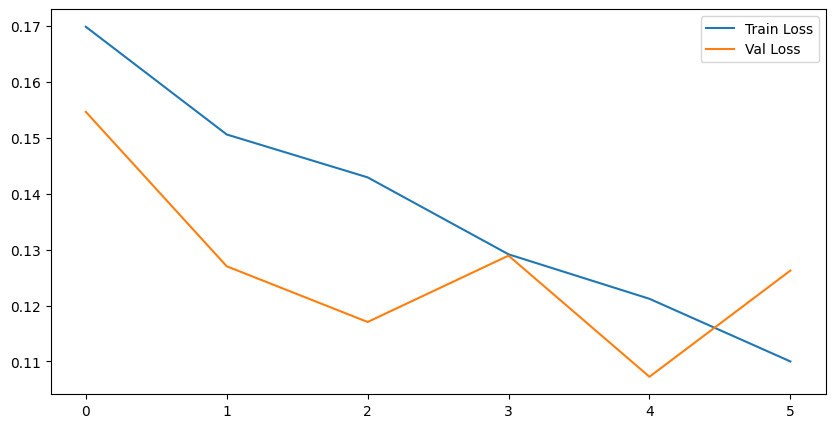

In [14]:
# ----------------------------
# Stage 1: Train only head
# ----------------------------
model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs_stage1)


Epoch 1/20
--------------------
Train Loss: 0.0464 Acc: 0.9845
Val   Loss: 0.0152 Acc: 0.9946
Epoch 2/20
--------------------
Train Loss: 0.0168 Acc: 0.9930
Val   Loss: 0.0072 Acc: 0.9982
Epoch 3/20
--------------------
Train Loss: 0.0082 Acc: 0.9973
Val   Loss: 0.0059 Acc: 0.9964
Epoch 4/20
--------------------
Train Loss: 0.0109 Acc: 0.9960
Val   Loss: 0.0098 Acc: 0.9946
Epoch 5/20
--------------------
Train Loss: 0.0074 Acc: 0.9980
Val   Loss: 0.0082 Acc: 0.9964
Epoch 6/20
--------------------
Train Loss: 0.0025 Acc: 0.9998
Val   Loss: 0.0039 Acc: 0.9982
Epoch 7/20
--------------------
Train Loss: 0.0064 Acc: 0.9971
Val   Loss: 0.0126 Acc: 0.9982
Epoch 8/20
--------------------
Train Loss: 0.0017 Acc: 1.0000
Val   Loss: 0.0032 Acc: 0.9982
Epoch 9/20
--------------------
Train Loss: 0.0028 Acc: 0.9989
Val   Loss: 0.0178 Acc: 0.9910
Epoch 10/20
--------------------
Train Loss: 0.0036 Acc: 0.9993
Val   Loss: 0.0049 Acc: 0.9982
Epoch 11/20
--------------------
Train Loss: 0.0009 Acc: 0.

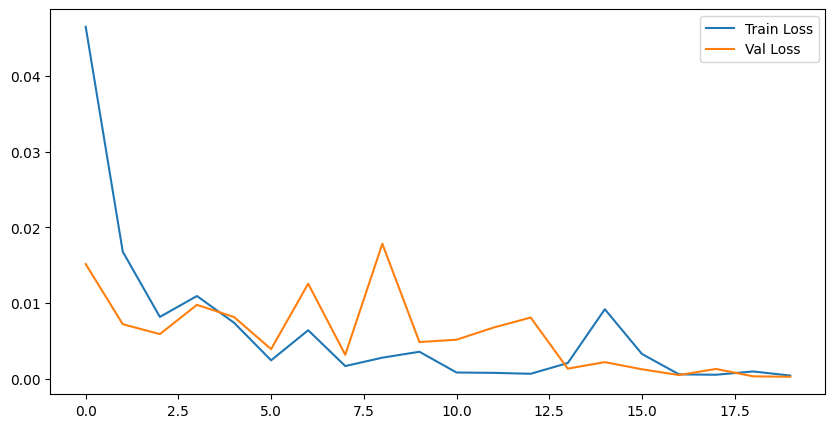

In [15]:
# ----------------------------
# Stage 2: Fine-tune backbone
# ----------------------------
for param in model.features.parameters():
    param.requires_grad = True

optimizer = optim.AdamW(model.parameters(), lr=learning_rate_stage2)
model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs_stage2)

In [16]:
# ----------------------------
# Evaluate on test set
# ----------------------------
model.eval()
test_corrects = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)

test_acc = test_corrects.float() / len(test_loader.dataset)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9964


In [17]:
# Save
torch.save(model.state_dict(), "efficientnet_b2_denty.pth")

In [18]:
# Load
model = models.efficientnet_b2(pretrained=False)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 2)  # binary classification head
model.load_state_dict(torch.load("efficientnet_b2_denty.pth", map_location=device))
model.to(device)
model.eval()

/Users/yerzhantemirali/Desktop/DECENTRATON/decentraton/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/yerzhantemirali/Desktop/DECENTRATON/decentraton/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [19]:
from torchvision import transforms
from PIL import Image
import torch

# Preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize((260, 260)),  # same size you used in training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [23]:
# Replace with your test image path
img_path = "/Users/yerzhantemirali/Desktop/DECENTRATON/telegram_dent/image (3).png"

# Load and preprocess
img = Image.open(img_path).convert("RGB")
input_tensor = preprocess(img).unsqueeze(0)  # add batch dimension
input_tensor = input_tensor.to(device)

# Forward pass
with torch.no_grad():
    outputs = model(input_tensor)
    probs = torch.softmax(outputs, dim=1)
    pred_class = torch.argmax(probs, dim=1).item()

# Map prediction to label
class_names = ["clean", "dusty"]  # adjust if reversed in training
print(f"Prediction: {class_names[pred_class]} (confidence {probs[0][pred_class].item():.2f})")

Prediction: dusty (confidence 1.00)
